In [47]:
import numpy as np
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn import svm
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
import catboost

from sklearn.ensemble import VotingRegressor, VotingClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [48]:
def load_data(y):
    path = '../../data/std_data/'
    x_train_std = pd.read_pickle(path +'train/{}_x.pkl'.format(str(y))).values
    x_test_std = pd.read_pickle(path +'test/{}_x.pkl'.format(str(y))).values
    y_train = pd.read_pickle(path +'train/{}_y.pkl'.format(str(y))).values
    y_test = pd.read_pickle(path +'test/{}_y.pkl'.format(str(y))).values
    features = pd.read_pickle(path +'train/{}_x.pkl'.format(str(y))).columns
    return x_train_std, x_test_std, y_train, y_test, features

In [49]:
def plot_roc_curve(fpr, tpr, auc):
    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

In [51]:
def create_models():
    
    sv = svm.SVR(kernel="sigmoid",
                                 degree=4,
                                 gamma=0.043502212815589775,
                                 coef0=0.20190829020616494,
                                 tol=0.0001,
                                 C=0.000245786293391316,
                                 epsilon=0.3056167642389302,
                                verbose=True,)

    xgboost = xgb.XGBRegressor(silent= True, 
                           max_depth=4,
                           learning_rate=0.12765177534095626,
                           n_estimators = 46,
                           gamma=0.060805284848630535,
                           reg_lambda=4.995675788308118,
                           reg_alpha=2.1912254426545754,
                           sub_sample=0.45297631180790854,
                           scale_pos_weight=1.1672978934986058)

    lgbm = lgb.LGBMRegressor(
        random_state=0,
        verbosity=-1,
        bagging_seed=0,
        boost_from_average='true',
        metric='auc',
        bagging_freq=4,
        min_data_in_leaf=21,
        max_depth=13,
        learning_rate=0.08731913651405197,
        n_estimators=3394,
        subsample=0.7054763057027115,
        num_leaves=438,
        reg_lambda=0.9377125325944119,  
    )
    
    cb = catboost.CatBoostRegressor(
        iterations=258,
        depth=2,
        learning_rate=0.019083573879517587,
        random_strength=84,
        bagging_temperature=0.3233702745357832,
        od_type="Iter",
        od_wait=32, 
        logging_level='Silent')
    
    mlp = MLPRegressor(hidden_layer_sizes=(32,),
                           activation='relu',
                           solver='adam',
                           alpha=4.76324733221396,
                           batch_size='auto',
                           learning_rate='constant', 
                           learning_rate_init=0.0012043271455668674, 
                           power_t=0.5,
                           max_iter=1000, 
                           shuffle=True,
                           random_state=0, 
                           tol=0.0001, 
                           verbose=False, 
                           warm_start=False, 
                           momentum=0.9,
                           nesterovs_momentum=True, 
                           early_stopping=False, 
                           validation_fraction=0.1, 
                           beta_1=0.022158342014810775, 
                           beta_2= 0.7802116425099002,
                           epsilon=1e-08,
                           )

#     estimators_rgs = [('sv', sv), ('xgboost', xgboost), ('lgbm', lgbm)]
    estimators_rgs = [('mlp', mlp)]
    
    return estimators_rgs

In [52]:
def main():
    
    
    path = '../../data/dataframes/std_data/'
#     df =  pd.read_pickle('../../data/dataframes/unificated_data_set.pkl')
    
    cm_all = np.zeros((2, 2))
    
    # 予測した確率全体を格納
    probs_all = np.array([])
    y_true_all = np.array([])
    
    for y in range(1978, 2020):
        
        # データの生成
        x_train, x_test, y_train, y_test, features = load_data(y)
       
        # 学習
        estimators= create_models()
        
        vr = VotingRegressor(estimators)

        vr.fit(x_train, y_train)
        
        # 予測(確率)
        probs = vr.predict(x_test)
        probs_all = np.hstack((probs_all, probs))
        y_true_all = np.hstack((y_true_all, y_test))
        
        print(probs)

        # 混同行列
        y_pred = np.where((probs ==  max(probs)), 1, 0) #確率→0/1
        cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
        cm_all += cm
    
    auc = roc_auc_score(y_true_all, probs_all)
    fpr, tpr, thresholds = roc_curve(y_true_all, probs_all)
    
    plot_roc_curve(fpr, tpr, auc)
    
    print("len: {0} , {1}".format(len(y_true_all), len(probs_all) ))
    print("confusion_matrix: ")
    print(cm_all)
    print("AUC: ")
    print(auc)
    print()
    return

[0.27105819 0.21486557 0.22578417 0.1748084  0.2572222 ]
[0.22279672 0.14524626 0.20878646 0.31003073 0.19906903]
[0.31195666 0.37003619 0.12968786 0.26742693 0.20255479]
[0.26169347 0.14000239 0.18114174 0.17663866 0.2167268 ]
[0.21107366 0.31928061 0.2465081  0.34875607 0.13330491]
[0.38057325 0.13167861 0.22115996 0.25580041 0.171949  ]
[0.14838404 0.24552347 0.12264823 0.24014278 0.18749252]
[0.23814254 0.12403014 0.18922784 0.11112023 0.12624132]
[0.09658062 0.17800665 0.20604192 0.17823208 0.17919123]
[0.1338006  0.18911603 0.1712683  0.16279898 0.14066144]
[0.33918351 0.12624184 0.14163888 0.15659969 0.135486  ]
[0.19264139 0.16373678 0.18058195 0.19176002 0.15544452]
[0.33169427 0.18495198 0.16072156 0.1666525  0.16345717]
[0.30419849 0.2247354  0.14530922 0.15849684 0.22752629]
[0.36777025 0.16916841 0.20507829 0.16299639 0.140214  ]
[0.37805296 0.20043401 0.12854867 0.15223956 0.21073067]
[0.18352174 0.36594901 0.18388939 0.23530854 0.12931408]
[0.23548063 0.1494374  0.122913

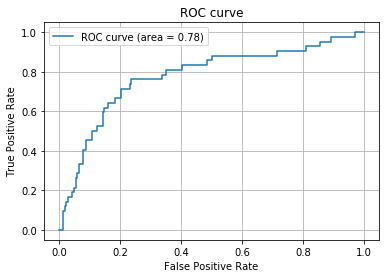

len: 211 , 211
confusion_matrix: 
[[153.  16.]
 [ 16.  26.]]
AUC: 
0.777120315581854



In [53]:
main()

In [ ]:
# xgboost: 
# 0.7607072414764722

# svm
# 0.794590025359256

# lgbm
# 0.7602141448295294

# ('sv', sv), ('xgboost', xgboost),
# 0.7603550295857988

# ('xgboost', xgboost), ('lgbm', lgbm)
# 0.7772612003381234

# ('sv', sv), ('lgbm', lgbm)
# 0.7606367990983375

# ('sv', sv), ('xgboost', xgboost), ('lgbm', lgbm)
# 0.7774020850943928

# cb
# 0.7561284868977177

# cb + xgb
# 0.7583826429980277

# cb + lgb
# 0.7700760777683854

# cb + lgb + xgb
# 0.7795153564384333

# sv + cb + lgb + xgb
# 0.7797971259509721